In [134]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from openvino.inference_engine import IECore
import tensorflow as tf
import easyocr 
ie  = IECore()
image_path = r'data_images\Untitled2.png'
image = cv2.imread(image_path)
def show(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [135]:
def detect_license_plate(image):
    license_plate_xml = r'models\vehicle-license-plate-detection-barrier-0106\vehicle-license-plate-detection-barrier-0106.xml'
    license_plate_bin = r'models\vehicle-license-plate-detection-barrier-0106\vehicle-license-plate-detection-barrier-0106.bin'
    net = ie.read_network(model=license_plate_xml, weights=license_plate_bin)
    ext = ie.load_network(network=net, device_name='CPU')
    resized_image = cv2.resize(image, (300, 300))
    image_for_inference = np.transpose(resized_image, (2, 0, 1))
    image_for_inference = np.expand_dims(image_for_inference, axis=0)
    results = ext.infer(inputs={'Placeholder': image_for_inference})
    
    # Retrieve the output blob
    output_blob = next(iter(net.outputs))

    # Process the output
    output = results[output_blob]
    boxes = output[0][0]
    license_plate_images = []
    if output.shape[0] == 0:
        print("No license plates detected.")
    else:
        for box in boxes:
            confidence = box[2]
            if confidence > 0.005: 
                # Filter detections based on confidence threshold
                x_min = int(box[3] * image.shape[1])
                y_min = int(box[4] * image.shape[0])
                x_max = int(box[5] * image.shape[1])
                y_max = int(box[6] * image.shape[0])
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                license_plate_image = image[y_min:y_max, x_min:x_max]
                license_plate_images.append(license_plate_image)
                
    return license_plate_images


In [136]:
license_plate_images = detect_license_plate(image)
image_for_inference = cv2.cvtColor(license_plate_images[0], cv2.COLOR_BGR2GRAY)

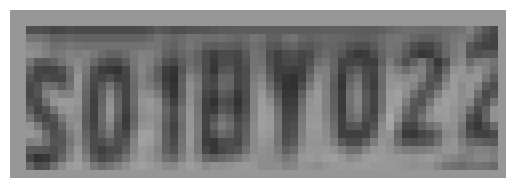

In [137]:
show(image_for_inference)

In [138]:
reader = easyocr.Reader(['en'])
extracted_text = []
results = reader.readtext(image_for_inference)
for detection in results:
        box, text, confidence = detection
        extracted_text.append(text)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [139]:
extracted_text

['50 107024']

In [132]:
text_encoder_xml = r'models\text-recognition-0014\text-recognition-0014.xml'
text_encoder_bin = r'models\text-recognition-0014\text-recognition-0014.bin'
net = ie.read_network(model=text_encoder_xml, weights=text_encoder_bin)
ext = ie.load_network(network=net, device_name='CPU')

resized_image = cv2.resize(image, (128, 32))
image_for_inference = np.expand_dims(resized_image, axis=0)
image_for_inference = np.expand_dims(image_for_inference, axis=1) 
image_for_inference = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

results = ext.infer(inputs={'imgs': image_for_inference})
Blob = results['logits']

blob = Blob.reshape(-1, 1, 37)  # Reshape to (W, B, L)

beam_width = 5  # Beam width for the decoder
top_paths = 1  # Number of top paths to retrieve

decoded_sparse = tf.nn.ctc_beam_search_decoder(inputs=blob, sequence_length=[blob.shape[0]], beam_width=beam_width, top_paths=top_paths)
decoded_text = tf.sparse.to_dense(decoded_sparse[0][0]).numpy().tolist()
print(decoded_text[0])
mapping = "0123456789abcdefghijklmnopqrstuvwxyz"
decoded_text = ''.join([mapping[i] for i in decoded_text[0]])

[16, 0, 31, 0, 28, 0, 16, 0]


In [133]:
decoded_text

'g0v0s0g0'

In [41]:
def obtain_predicted_letter(decoder_output):
    # Define the list of supported symbols
    supported_symbols = "?0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

    # Get the index with the highest probability from the decoder output
    predicted_index = np.argmax(decoder_output)

    # Map the index to the corresponding symbol
    predicted_letter = supported_symbols[predicted_index]

    return predicted_letter


text_encoder_xml = r'models\text-recognition-0014\text-recognition-0014.xml'
text_encoder_bin = r'models\text-recognition-0014\text-recognition-0014.bin'
net = ie.read_network(model=text_encoder_xml, weights=text_encoder_bin)
ext = ie.load_network(network=net, device_name='CPU')

resized_image = cv2.resize(license_plate_images[0], (256, 64))
image_for_inference = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
image_for_inference = np.expand_dims(image_for_inference, axis=0)
image_for_inference = np.expand_dims(image_for_inference, axis=1)  # Add channel dimension

results_encoder = ext.infer(inputs={'imgs': image_for_inference})
decoder_hidden = results_encoder['decoder_hidden']
features = results_encoder['features']

text_decoder_xml = r'models\text-recognition-0016\text-recognition-0016-decoder\text-recognition-0016-decoder.xml'
text_decoder_bin = r'models\text-recognition-0016\text-recognition-0016-decoder\text-recognition-0016-decoder.bin'
net_decoder = ie.read_network(model=text_decoder_xml, weights=text_decoder_bin)
ext_decoder = ie.load_network(network=net_decoder, device_name='CPU')

decoder_input = np.array([0])  # Placeholder for previous predicted letter
hidden = decoder_hidden
text = ""

char_dict = {symbol: i for i, symbol in enumerate("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ", start=1)}

for step in range(10):
    results_decoder = ext_decoder.infer(inputs={'decoder_input': decoder_input, 'features': features, 'hidden': hidden})
    decoder_hidden = results_decoder['decoder_hidden']
    decoder_output = results_decoder['decoder_output']
    
    # Obtain the predicted letter from the decoder output
    predicted_letter = obtain_predicted_letter(decoder_output)
    text += predicted_letter
    print(predicted_letter)
    
    # Set decoder_input to the predicted letter index for the next time step
    decoder_input = np.array([char_dict[predicted_letter.lower()]], dtype=np.int32)



TypeError: Got an unexpected keyword argument 'merge_repeated'

1